# 2D Gaussian tomography

## Imports

In [2]:
#Imports
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras import layers
from tensorflow.keras.utils import plot_model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from skimage.metrics import structural_similarity as ssim
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.optimize import minimize
from datetime import datetime

## Useful functions

In [3]:
# input: (60000,28,28); output: (60000,28,28,1)
def reshape_for_CNN(coarse_train,coarse_test,dim):

  coarse_train=np.reshape(coarse_train, (len(coarse_train), dim[0], dim[1], 1))
  coarse_test=np.reshape(coarse_test, (len(coarse_test), dim[0], dim[1], 1))
  return coarse_train,coarse_test

In [4]:
# take in (60000,28,28) ; specify dim to upscale; coarsen, normalize;   output: either (x1*x2) or (x1, x2, 1)
def upscale_normalize_reshape(train_x,test_x,dim,cnn):
# dim=(n,n); 
# train_x.shape - (60000,28,28)

    train_x=train_x.astype('float32')
    test_x= test_x.astype('float32')

    #train_x=np.reshape(train_x, (len(train_x), int(train_x.shape[1]), int(train_x.shape[1]))) # if 
    #test_x=np.reshape(test_x, (len(test_x), int(test_x.shape[1]), int(test_x.shape[1])))

    # coarsen training data
    coarse_train=np.zeros((train_x.shape[0],dim[0],dim[1]))
    for i in range(train_x.shape[0]):
        coarse_train[i] = cv2.resize(train_x[i], dim, interpolation = cv2.INTER_AREA)
        
    #coarsen test data
    coarse_test=np.zeros((test_x.shape[0],dim[0],dim[1]))
    for i in range(test_x.shape[0]):
        coarse_test[i] = cv2.resize(test_x[i], dim, interpolation = cv2.INTER_AREA)

    # normalize
    coarse_train=coarse_train.astype('float32') / np.absolute(coarse_train).max()
    coarse_test=coarse_test.astype('float32') / np.absolute(coarse_test).max()
    
    if cnn==True:
        coarse_train,coarse_test=reshape_for_CNN(coarse_train,coarse_test,dim)
    else:
        coarse_train=np.reshape(coarse_train, (len(coarse_train), dim[0]*dim[1]))
        coarse_test=np.reshape(coarse_test, (len(coarse_test), dim[0]*dim[1]))
    return coarse_train, coarse_test

In [5]:
# take 2 images and plot: 1) top: original 2) bottom: reconstruction
def plot_reconstruction1(original,reconstruction,dim1,dim2):


  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.title('Original fine test')

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.title('Reconstructed test')
  plt.colorbar()
  plt.show()

## Data Generation

In [6]:
gaussian_data = np.load(r'C:\Users\Mahammad\OneDrive\Desktop\USC_2021\Research\Data_assimilation\Multiscale_HM_ENKF\Multiscale_gradient_based\RSC_2023\Gaussian\gaussian_data_5000_16384.npy')
gaussian_data.shape

(5000, 16384)

In [7]:
# Split to train, test

x_train=gaussian_data[:4500]          # 450
print(x_train.shape)
x_test=gaussian_data[4500:]        # 50
print(x_test.shape)


x_train=np.reshape(x_train, (len(x_train),128, 128))
x_test=np.reshape(x_test, (len(x_test), 128, 128))
print(x_train.shape)
print(x_test.shape)

(4500, 16384)
(500, 16384)
(4500, 128, 128)
(500, 128, 128)


(4500, 64, 64)
(500, 64, 64)
4.84133
-5.66942


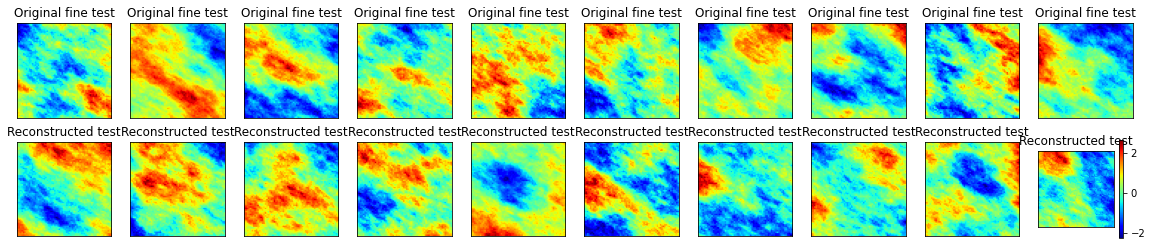

In [8]:
# Crop 64x64

x_train=x_train[:,32:96,32:96]
x_test=x_test[:,32:96,32:96]
print(x_train.shape)
print(x_test.shape)
print(x_train.max())
print(x_train.min())
plot_reconstruction1(x_train,x_test,64,64)

In [9]:
# Assign train data to 64x64

train64_64nd, test64_64nd=(x_train, x_test)
print(train64_64nd.shape)
print(np.histogram(train64_64nd))
print(train64_64nd.max())
print(train64_64nd.min())

(4500, 64, 64)
(array([    143,    2248,   85289, 1101297, 4889208, 7519845, 4048490,
        736990,   47729,     761], dtype=int64), array([-5.66942 , -4.618345, -3.56727 , -2.516195, -1.46512 , -0.414045,
        0.63703 ,  1.688105,  2.73918 ,  3.790255,  4.84133 ]))
4.84133
-5.66942


In [10]:
# upscale_reshape_normalize

train8_8dn, test8_8dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(8,8),cnn=False)
train8_8cnndn, test8_8cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(8,8),cnn=True)

train16_16dn, test16_16dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(16,16),cnn=False)
train16_16cnndn, test16_16cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(16,16),cnn=True)

train32_32dn, test32_32dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(32,32),cnn=False)
train32_32cnndn, test32_32cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(32,32),cnn=True)

train64_64dn, test64_64dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(64,64),cnn=False)
train64_64cnndn, test64_64cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(64,64),cnn=True)

#train28_28dn, test28_28dn=train28_28nd, test28_28nd
print(train8_8dn.shape)
print(train8_8cnndn.shape)
print(np.histogram(train8_8dn))
print(train16_16dn.shape)
print(np.histogram(train16_16dn))
print(train32_32dn.shape)
print(np.histogram(train32_32dn))
print(train64_64dn.shape)
print(np.histogram(train64_64dn))
print(train8_8dn.min())
print(train8_8dn.max())
print(train16_16dn.min())
print(train16_16dn.max())
print(train32_32dn.min())
print(train32_32dn.max())
print(train64_64dn.min())
print(train64_64dn.max())

(4500, 64)
(4500, 8, 8, 1)
(array([     6,     84,   2060,  18049,  67453, 106311,  71718,  19858,
         2330,    131], dtype=int64), array([-1.        , -0.8186204 , -0.63724077, -0.45586112, -0.2744815 ,
       -0.09310189,  0.08827773,  0.26965734,  0.451037  ,  0.6324166 ,
        0.8137962 ], dtype=float32))
(4500, 256)
(array([    14,    175,   5546,  61936, 269387, 448429, 289373,  70320,
         6573,    247], dtype=int64), array([-1.        , -0.81880665, -0.6376133 , -0.45641997, -0.27522665,
       -0.0940333 ,  0.08716004,  0.26835337,  0.44954672,  0.63074005,
        0.8119334 ], dtype=float32))
(4500, 1024)
(array([     46,     574,   20547,  253838, 1137248, 1845123, 1099580,
        232582,   18011,     451], dtype=int64), array([-1.        , -0.8170468 , -0.6340936 , -0.4511404 , -0.2681872 ,
       -0.08523399,  0.09771921,  0.28067243,  0.4636256 ,  0.64657885,
        0.829532  ], dtype=float32))
(4500, 4096)
(array([    143,    2248,   85289, 1101297, 4889208,

# Import trained models (import, predict, plot)

In [11]:
AE256 = keras.models.load_model('AE256.h5')
AE256.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 8)         520       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 8)         0   

(500, 64, 64, 1)
-0.8684528:64:0.9340889


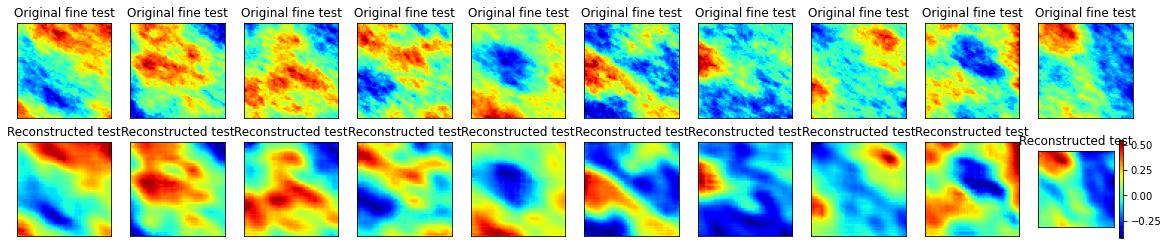

In [12]:
#predict
pred64_64fAE256 = AE256.predict(test64_64cnndn)
print(pred64_64fAE256.shape)
print(str(pred64_64fAE256.min())+':64:'+str(pred64_64fAE256.max()))
#plot predictions from model
plot_reconstruction1(test64_64dn,pred64_64fAE256,64,64)

## Crop the model: 1) 8-16  2) 8-32  3) 8-64  4) 16-32  5) 16-64 6) 32-64

In [13]:
# model_input to z

model_inputforw = keras.Input(shape=(64,64,1)) #20

mdforw  = AE256.layers[-26](model_inputforw)
#md16_64  = model_1.layers[-19](md16_64)
#md16_64  = model_1.layers[-18](md16_64)
#md16_64  = model_1.layers[-17](md16_64)
#md16_64  = model_1.layers[-16](md16_64)
#md8_64  = model_1.layers[-26](md8_64)
mdforw  = AE256.layers[-25](mdforw)
mdforw  = AE256.layers[-24](mdforw)
mdforw  = AE256.layers[-23](mdforw)
mdforw  = AE256.layers[-22](mdforw)
mdforw  = AE256.layers[-21](mdforw)
mdforw  = AE256.layers[-20](mdforw)
mdforw  = AE256.layers[-19](mdforw)
mdforw  = AE256.layers[-18](mdforw)
mdforw  = AE256.layers[-17](mdforw)
mdforw  = AE256.layers[-16](mdforw)
mdforw  = AE256.layers[-15](mdforw)
#mdforw  = model_1.layers[-14](mdforw)

# create the decoder model
model_forw= keras.Model(model_inputforw, mdforw)
model_forw.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 8)         520       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 8)         0     

In [14]:
# model_z to output

model_inputback = keras.Input(shape=(256,)) #20

mdback  = AE256.layers[-14](model_inputback)
#md16_64  = model_1.layers[-19](md16_64)
#md16_64  = model_1.layers[-18](md16_64)
#md16_64  = model_1.layers[-17](md16_64)
#md16_64  = model_1.layers[-16](md16_64)
mdback  = AE256.layers[-13](mdback)
mdback  = AE256.layers[-12](mdback)
mdback  = AE256.layers[-11](mdback)
mdback  = AE256.layers[-10](mdback)
mdback  = AE256.layers[-9](mdback)
mdback  = AE256.layers[-8](mdback)
mdback  = AE256.layers[-7](mdback)
mdback  = AE256.layers[-6](mdback)
mdback  = AE256.layers[-5](mdback)
mdback  = AE256.layers[-4](mdback)
mdback  = AE256.layers[-3](mdback)
mdback  = AE256.layers[-2](mdback)
mdback  = AE256.layers[-1](mdback)

# create the decoder model
model_back= keras.Model(model_inputback, mdback)
model_back.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              263168    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 16)          6416      
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8, 8, 16)          0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 16, 16, 16)        0   

# G and flow data

In [15]:
# local
import scipy.io
G_global= scipy.io.loadmat('G32_32_2way.mat')
G_global =G_global['G32_32_2way']
print(G_global.shape)
print(type(G_global))


(2048, 1024)
<class 'numpy.ndarray'>


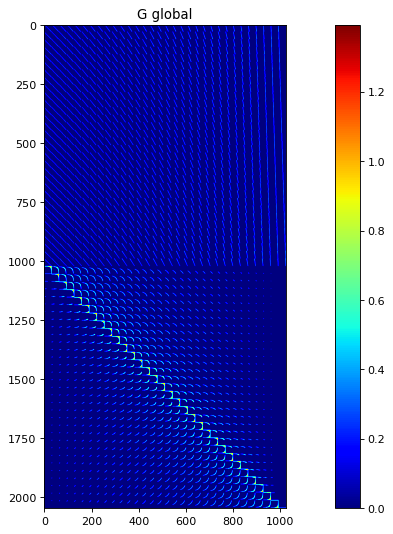

In [16]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(G_global)
plt.jet()
plt.title('G global')
plt.colorbar()
plt.show()


In [17]:
for i in range(G_global.shape[0]):
    a=G_global[i,:]
    a=np.reshape(a,(32,32))
    a=a.T
    a=a.flatten()
    G_global[i,:]=a
print(G_global.shape)

(2048, 1024)


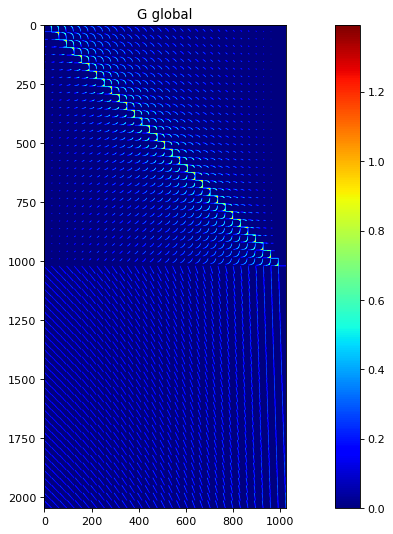

In [18]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(G_global)
plt.jet()
plt.title('G global')
plt.colorbar()
plt.show()
G_global=G_global.T

## Gradient-based data assimilation

(4096,)
-0.6413801
0.467241


Text(0.5, 1.0, 'Ref model')

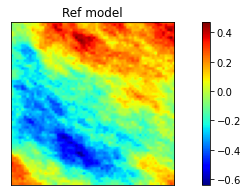

In [19]:
# Choose reference

ref=0

m_ref=np.squeeze(test64_64dn[ref:ref+1,:].T)
print(m_ref.shape)
print(m_ref.min())
print(m_ref.max())

# Plot reference

f = plt.figure(figsize=(10, 3))
plt.imshow(np.reshape(m_ref, [64, 64]),aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model")


In [20]:
# Generate flow data
m_ref2=m_ref.copy()
m_ref2=np.reshape(m_ref2,(64,64))
m_ref2=m_ref2[0:32,0:32].flatten()
m_ref2=np.squeeze(m_ref2)
print(m_ref2.shape)

d_obs_global = np.reshape(m_ref2, [1, m_ref2.shape[0]])@G_global
d_obs_global= np.squeeze(d_obs_global)



print(d_obs_global.shape) # (128,)
print(max(d_obs_global))
print(min(d_obs_global))



print(d_obs_global)

(1024,)
(2048,)
7.052306975818009
-8.75322338938713
[5.0188168  5.0212668  4.37709675 ... 2.98954295 2.99101792 2.90701149]


15.930395
-4.6950226
(500, 256)


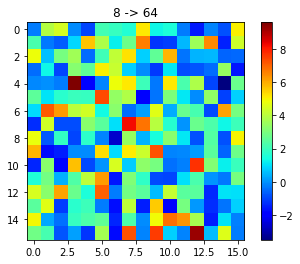

In [22]:
latent_space_test  = model_forw.predict(test64_64cnndn)

# Display reconstruction
plt.imshow(latent_space_test[1].reshape(16, 16))
plt.jet()

plt.title('8 -> 64')
#plt.clim(-0.2, 0.6)
plt.colorbar()
#plt.show()

print(latent_space_test.max())
print(latent_space_test.min())
print(latent_space_test.shape)

## 8x8 Global

In [23]:
#callback to monitor optimization process
from IPython.display import clear_output

i8glob = 0
x8glo = []
losses8glo = []
logs8glo = []
grad8glo=[]
interm_sol8glo=[]
interm_sol64_8glo=[]

def monitor8global(xk):
    
    global i8glob, x8glo, losses8glo, logs8glo, grad8glo, interm_sol8glo, interm_sol64_8glo, grad_v8glo
    
    fig = plt.figure(figsize=[15, 4])

    logs8glo.append(logs8glo)
    x8glo.append(i8glob)
    losses8glo.append(func8global(xk))
    i8glob += 1
    
    clear_output(wait=True)
    
    plt.subplot(1, 3, 1)
    plt.plot(x8glo, losses8glo, label="loss", c = 'green')
    plt.ylabel("Loss function")
    plt.xlabel("Iter.")
    plt.title("Loss vs iter.")
    
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.reshape(xk, [16, 16]), aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model 8x8")
    #plt.clim(0, 1)
    plt.colorbar()
    

    interm_sol8glo.append(xk)
    xk=np.reshape(xk,(1,256))
    grad8glo.append(dldm8global(xk))
    xk = model_back.predict(xk)
    interm_sol64_8glo.append(xk)
    
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.reshape(xk, [64, 64]), aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model 64x64")
    #plt.clim(0, 1)
    plt.colorbar()
    plt.show()
    

In [24]:
#objective function
def func8global(z8): #m5: 25-dimensional vector

    z8cnn=np.reshape(z8,(1,256))
    pred64_64f5_1  = model_back.predict(z8cnn)   
    
    m64=np.reshape(pred64_64f5_1,(64,64))
    m64=m64[0:32,0:32]
    m64=m64.flatten()
    m64=np.squeeze(m64)
    
    obj=np.sqrt(np.mean(np.square(G_global.T@m64 - d_obs_global)))
    
    return obj

In [25]:
def dldm8global(z8):

    grad_L=np.zeros((256,1))
    z8=np.reshape(z8,(256,1))
    m01=np.zeros((256,1))
    m02=np.zeros((256,1))
    s8=np.arange(0,256)
    for i in range(256):
        dx=0.05
        dum1=np.zeros((256,1))
        dum1[s8[i],0]=dx
        m01=z8+dum1
        m02=z8-dum1
        L1=func8global(m01)
        L2=func8global(m02)
        grad_L[s8[i]]=(L1-L2)/(2*dx)
    grad_L=np.squeeze(grad_L)
    
    print(grad_L)
    return grad_L

In [26]:
from scipy.optimize import Bounds
bounds256 =()
mm=[-5,16]
for i in range(256):
    bounds256=bounds256+(mm,)
len(bounds256)

256

[-5.62689764e-03 -3.26468739e-03 -1.97222997e-03  4.09478983e-03
  1.24872621e-03  1.76305323e-03 -2.55278139e-04 -4.47492676e-04
 -1.41047434e-03 -7.75159408e-04  5.88692805e-03  2.28147778e-03
  6.90099101e-04  1.11475112e-04  5.95565447e-04 -7.81090099e-04
  2.75523672e-03  1.63678736e-03 -2.55679764e-03  1.55471863e-03
  6.24359573e-03  1.69503179e-03  8.60644120e-04  1.50481295e-03
 -2.27840459e-04 -7.23358723e-04 -1.03557770e-03 -9.86267892e-04
 -3.56988333e-04 -2.28086028e-03  1.49622735e-03 -3.19690845e-03
 -4.44585518e-03  2.64086645e-03 -5.95277423e-04  6.86442735e-03
  1.56304623e-03  2.30337395e-03 -2.33608105e-03  1.32187517e-03
  1.97844067e-03 -1.34491931e-03  3.28175885e-03  3.73522162e-04
  7.85222089e-04 -2.78072039e-03 -4.98493643e-04  3.19207098e-03
 -5.33114188e-03  2.90932496e-03 -1.87083706e-03 -5.40877840e-03
  4.76680194e-03  7.78299938e-04 -2.58276432e-03 -8.81506533e-03
  1.56550429e-03  1.80454126e-03  1.22851112e-03  2.11476442e-03
  2.12013339e-03 -2.91144

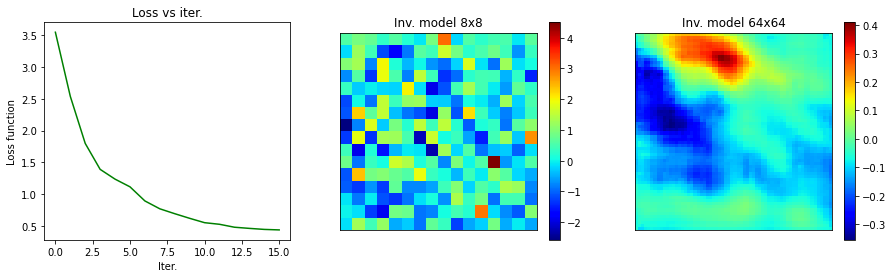

(256, 1)


In [27]:
# optimization; add time

#initial guess (sensitive!)
m08glo = np.zeros([256, 1])
#m08glo=np.reshape(m0_ens8x8,[64,1])
print(m08glo.shape)


#minimize the objective function
res8glob = minimize(func8global, m08glo, method='L-BFGS-B', jac=dldm8global, callback=monitor8global, options={'gtol': 1e-2, 'disp': True},bounds=bounds256)


m_sol8glo = np.expand_dims(res8glob.x, axis=-1)
print(m_sol8glo.shape)

In [28]:
from winsound import Beep
Beep(1000,1000)

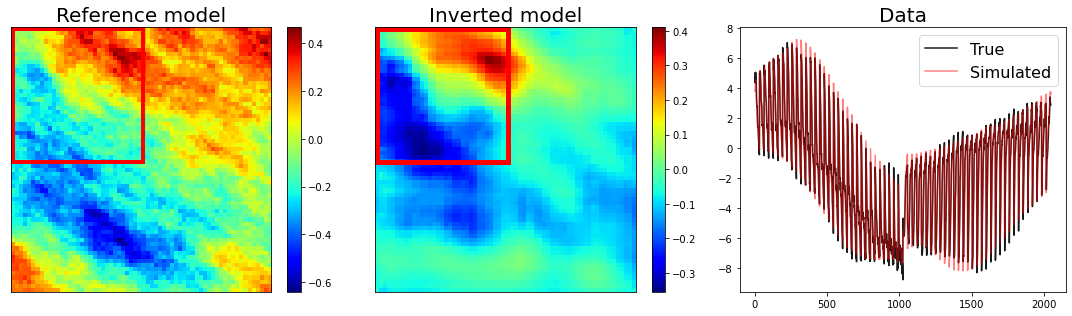

In [29]:
#forward simulation on the inverted model
from matplotlib.patches import Rectangle
from PIL import Image
m_sol8glo=np.reshape(m_sol8glo,(1,256))
m_sol64_8glo  = model_back.predict(m_sol8glo)

m_sol64_8glo1=np.reshape(m_sol64_8glo,(64,64))
m_sol64_8glo1=m_sol64_8glo1[0:32,0:32]
m_sol64_8glo1=m_sol64_8glo1.flatten()
m_sol64_8glo1=np.squeeze(m_sol64_8glo1)


y_sim8glo = (m_sol64_8glo1.T@G_global).T


m_ref=np.reshape(m_ref,(64,64))
m_sol64_8glo=np.reshape(m_sol64_8glo,(64,64))
#compare model and data (i.e. reference case vs solution)
f = plt.figure(figsize=(15, 4.5))
plt.subplot(1, 3, 1)
plt.imshow(np.reshape(m_ref, [64, 64]), aspect='auto')
plt.gca().add_patch(Rectangle((0,0),32,32,linewidth=4,edgecolor='r',facecolor='none'))
plt.xticks([]), plt.yticks([])
plt.title("Reference model",fontsize = 20)
plt.colorbar(shrink=1)

plt.subplot(1,3, 2)
#m_sol64_8glo[abs(m_sol64_8glo) < 0.02] = np.nan # or use np.nan
plt.imshow(np.reshape(m_sol64_8glo, [64, 64]), aspect='auto')
#current_cmap = plt.cm.get_cmap()
#current_cmap.set_bad(color='white')
plt.gca().add_patch(Rectangle((0,0),32,32,linewidth=5,edgecolor='r',facecolor='none'))
plt.xticks([]), plt.yticks([])
plt.title("Inverted model",fontsize = 20)
plt.colorbar(shrink=1)

plt.subplot(1, 3, 3)
plt.plot(d_obs_global, ls='-', c='k', label='True', alpha=0.9)
plt.plot(y_sim8glo, c='r', label='Simulated', alpha=0.5)
plt.title("Data",fontsize = 20)
plt.legend(loc=1, prop={'size': 16})

plt.tight_layout()
plt.savefig('Results2_AE_spatial',dpi=500)

In [30]:
## Metric
model_metric_8glob=np.sqrt(np.mean(np.square(m_sol64_8glo[:32,:32]-m_ref[:32,:32])))
model_metric_8glob = "{:.4f}".format(model_metric_8glob)    
data_metric_8glob=np.sqrt(np.mean(np.square(d_obs_global-y_sim8glo)))
data_metric_8glob = "{:.4f}".format(data_metric_8glob)
print(m_sol64_8glo.shape)
print(m_ref.shape)
print(d_obs_global.shape)
print(y_sim8glo.shape)
print('model error 8glob RMSE:'+str(model_metric_8glob))
print('data  error 8glob RMSE:'+str(data_metric_8glob))

(64, 64)
(64, 64)
(2048,)
(2048,)
model error 8glob RMSE:0.0610
data  error 8glob RMSE:0.4337
